In [1]:
from sympy import *
import numpy as np
import pandas as pd
import copy
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from sympy import symbols, init_printing
import matplotlib.pyplot as plt
from numpy.linalg import inv
import cmath
import os
import sys

# Initialize pretty printing
init_printing(use_unicode=True)
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = None

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from src.utils.equ_comp import *
from src.core.wrapper import *
from src.dae.equation_form import *
from src.utils.cal_send_v import *
from src.IO.xcel import *

import numpy as np
import os

In [2]:
# Define base path relative to the project directory
base_path = os.path.join(os.path.dirname(os.getcwd()), "validation_test\\Case_validation")
ac_case_name_pf = os.path.join(base_path, "ieee14_pll1_ssm_val.xlsx")
ac_case_sym = os.path.join(base_path, "ieee14.xlsx")
pf_saved_data = os.path.join(base_path, "pf_info_ieee14_ssm_val.xlsx")
val_file = os.path.join(base_path, "andes_td_val_data.xlsx")
ss_val_save_path = os.path.join(base_path, "andes_ss_val.txt")

In [3]:
system,bus,model,alg = ac_wrapper(ac_case_sym)

Default status SG params      M    D   xd   xq  xd1  xq1 Td10 Tq10   ra   Tm Rgov   Te   Ke Vref
0  num  num  num  num  num  num  num  num  num  num  num  num  num  num
Default status GFL params Empty DataFrame
Columns: [KpPLL, KiPLL, kdroop, xq, ra, kxl, Kp, Ki, Sl]
Index: []
Default status GFM params Empty DataFrame
Columns: [mp, mq, gamma, kpv, kiv, tau, xq, ra, Sl]
Index: []
Current status SG params      M    D   xd   xq  xd1  xq1 Td10 Tq10   ra   Tm Rgov   Te   Ke Vref
0  num  num  num  num  num  num  num  num  num  num  num  num  num  num
Current status GFL params Empty DataFrame
Columns: [KpPLL, KiPLL, kdroop, xq, ra, kxl, Kp, Ki, Sl]
Index: []
Current status GFM params Empty DataFrame
Columns: [mp, mq, gamma, kpv, kiv, tau, xq, ra, Sl]
Index: []


In [ ]:
f,g,x,y = ac_connection(system,bus,model,alg)

In [5]:
df = read_excel(pf_saved_data)
Veq = df['V']
Aeq = df['A']

Vext = list(np.zeros(len(alg.bus_extended))) 
Aext = list(np.zeros(len(alg.bus_extended))) 

Idext = list(np.zeros(len(alg.bus_extended)))
Iqext = list(np.zeros(len(alg.bus_extended)))

Pg = list(np.zeros(len(alg.bus_extended)))
Qg = list(np.zeros(len(alg.bus_extended)))

Vext[:len(list(system.bus['idx']))] = Veq
Aext[:len(list(system.bus['idx']))] = Aeq


for k in range(len(alg.branch_info_extended[len(system.line):,:])):
    orig_bus_idx = (alg.branch_info_extended[len(system.line):,:][k,0]).astype(int) - 1
    new_bus_idx = (alg.branch_info_extended[len(system.line):,:][k,1]).astype(int) - 1
    ra = alg.branch_info_extended[len(system.line):,:][k,2] 
    xq = alg.branch_info_extended[len(system.line):,:][k,3]
    # V_r = Veq[orig_bus_idx]*cos(Aeq[orig_bus_idx]) + 1j*Veq[orig_bus_idx]*sin(Aeq[orig_bus_idx])
    V_r = cmath.rect(Veq[orig_bus_idx], Aeq[orig_bus_idx])
    P_r = list(df['Pg'])[list(df['Bus No'])[orig_bus_idx]-1]*alg.extended_resource_name[k,1]
    Q_r = list(df['Qg'])[list(df['Bus No'])[orig_bus_idx]-1]*alg.extended_resource_name[k,1]
    Vext[new_bus_idx],Aext[new_bus_idx],Idext[new_bus_idx],Iqext[new_bus_idx],\
        Pg[new_bus_idx],Qg[new_bus_idx] = calculate_sending_end_voltage(V_r, P_r, Q_r, ra, xq)

display_data = {}
display_data['V_ext'] = np.array(Vext)
display_data['A_ext'] = np.array(Aext)
display_data['Idext'] = np.array(Idext)
display_data['Iqext'] = np.array(Iqext)
display_data['Pg'] = np.array(Pg)
display_data['Qg'] = np.array(Qg)
display_df = pd.DataFrame(display_data)

display_df

# print(display_df)
# print("AC bus Voltages (extended) (p.u.): \n", np.array(Vext))
# print("AC bus Angles (extended) (rad): \n", np.array(Aext))
# print("Id (gen buses): \n", np.array(Idext[len(list(system.bus['idx'])):]))
# print("Iq (gen buses): \n", np.array(Iqext[len(list(system.bus['idx'])):]))

,V_ext,A_ext,Idext,Iqext,Pg,Qg
0,1.030000,3.187019e-19,0.0,0.0,0.0,0.0
1,1.030000,-1.075122e-02,0.0,0.0,0.0,0.0
2,1.010000,-2.677523e-02,0.0,0.0,0.0,0.0
3,1.017241,-3.003939e-02,0.0,0.0,0.0,0.0
4,1.020529,-3.103063e-02,0.0,0.0,0.0,0.0
5,1.030000,-7.840999e-02,0.0,0.0,0.0,0.0
6,1.008435,-3.759195e-02,0.0,0.0,0.0,0.0
7,1.030000,2.179906e-02,0.0,0.0,0.0,0.0
8,0.992383,-8.015187e-02,0.0,0.0,0.0,0.0
9,0.991213,-8.519432e-02,0.0,0.0,0.0,0.0


In [6]:
values_check = {}
for k in range(len(system.bus)):
    values_check[bus.pl[k]] = list(df['Pload'])[k]
    values_check[bus.ql[k]] = list(df['Qload'])[k]

for k in range(len(system.gen)):
    r = np.where(alg.extended_resource_name.astype(str)==list(system.gen['name'])[k])[0]
    old_bus_idx = alg.extended_resource_name[r,2][0] - 1
    new_bus_idx = alg.extended_resource_name[r,3][0] - 1
    values_check[model.Q_g[k]] = Qg[new_bus_idx]  
    values_check[model.P_g[k]] = Pg[new_bus_idx]
    values_check[model.w_gen[k]] = 1

for k in range(len(alg.bus_extended)):
    values_check[bus.a[k]] = Aext[k]
    values_check[bus.v[k]] = Vext[k]

if max(abs(g.subs(values_check))) < 1e-5 and max(abs(f.subs(values_check))) < 1e-5:
    print("Correct Equilibrium")
else:
    print("Incorrect Equilibrium")

Correct Equilibrium


In [7]:
# compute jacobians
fx = f.jacobian(x)
fy = f.jacobian(y)
gx = g.jacobian(x)
gy = g.jacobian(y)

fx.simplify()
fy.simplify()
gx.simplify()
gy.simplify()

In [8]:
# assign variable values
values = {}
for k in range(len(alg.bus_extended)):
    values[bus.a[k]] = Aext[k]
    values[bus.v[k]] = Vext[k]

# for k in range(len(system.gfl)):
#     r = np.where(alg.extended_resource_name.astype(str)==list(system.gfl['name'])[k])[0]
#     new_bus_idx = alg.extended_resource_name[r,3][0] - 1
#     values[model.a_gfl[k]] = Aext[new_bus_idx]
#     values[model.w_gfl[k]] = 1
    

# compute A
fx_sub = fx.subs(values)
fy_sub = fy.subs(values)
gx_sub = gx.subs(values)
gy_sub = gy.subs(values)


inv_gy = inv(np.array(gy_sub,dtype=float))
A = fx_sub - fy_sub*inv_gy*gx_sub

threshold = 1e-4
# Evaluate the matrix with high precision
A_matrix = A.evalf(n=4)

# Apply the threshold to each element and set to zero if below the threshold
# for i in range(A_matrix.shape[0]):
#     for j in range(A_matrix.shape[1]):
#         if A_matrix[i, j].is_number:  # Skip non-symbols
#             if abs(A_matrix[i, j]) < threshold:
#                 A_matrix[i, j] = 0

print('A matrix:')
print('-------------------------')
pprint(A_matrix)

A matrix:
-------------------------
⎡   0        0        0        0        0      377.0     0       0      0      ↪
⎢                                                                              ↪
⎢   0        0        0        0        0        0     377.0     0      0      ↪
⎢                                                                              ↪
⎢   0        0        0        0        0        0       0     377.0    0      ↪
⎢                                                                              ↪
⎢   0        0        0        0        0        0       0       0    377.0    ↪
⎢                                                                              ↪
⎢   0        0        0        0        0        0       0       0      0    3 ↪
⎢                                                                              ↪
⎢-0.1482  0.05092  0.03541  0.03888  0.02299   -0.5      0       0      0      ↪
⎢                                                                        

In [9]:
eigenvalues = A_matrix.eigenvals()
# eigenvalues = round(eigenvalues, 5)
eigenvalues = list(eigenvalues)

print('Eigenvalues:')
for k in range(A_matrix.shape[0]):
    print(round(eigenvalues[k],5))

Eigenvalues:
-0.23415 - 8.22623*I
-0.19967 - 7.72375*I
-0.18049 - 7.38798*I
-0.19347 - 6.57354*I
-4.e-5
-0.39209
-0.23415 + 8.22623*I
-0.19967 + 7.72375*I
-0.18049 + 7.38798*I
-0.19347 + 6.57354*I


In [10]:
T = np.array([
    [-1, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # delta_2 - delta_1
    [-1, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # delta_3 - delta_1
    [-1, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # delta_4 - delta_1
    [-1, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # delta_5 - delta_1
    [ 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # omega_1
    [ 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # omega_2
    [ 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # omega_3
    [ 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # omega_4
    [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # omega_5
])

# A: 10x10 original system matrix
A = np.array(A_matrix)
T_inv = np.linalg.pinv(T)  # Use pseudo-inverse since T is not square
A_new = T @ A @ T_inv      # Result is 9x9 reduced system matrix


In [11]:
# ss_val = np.array([0.1912996,0.1870876,0.1918281,0.0625993,0.2035317,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000])
ss_val = np.loadtxt(ss_val_save_path)
val_data = pd.read_excel(val_file).to_numpy()
val_data_1 = val_data.copy()
val_data_2 = [ss_val - val_data[k,1:] for k in range(val_data.shape[0])]
val_data_1[:,1:] = val_data_2

In [12]:
def dV_dt(t, x):
    dx = np.matmul(A_new, x) 
    return dx

x0 = T @ val_data_2[0]
t_max = 3
dt = 0.033333333333333
t_eval = np.arange(0, t_max, dt)
sol = solve_ivp(dV_dt, [0, t_max], x0, t_eval=t_eval, method='RK45')

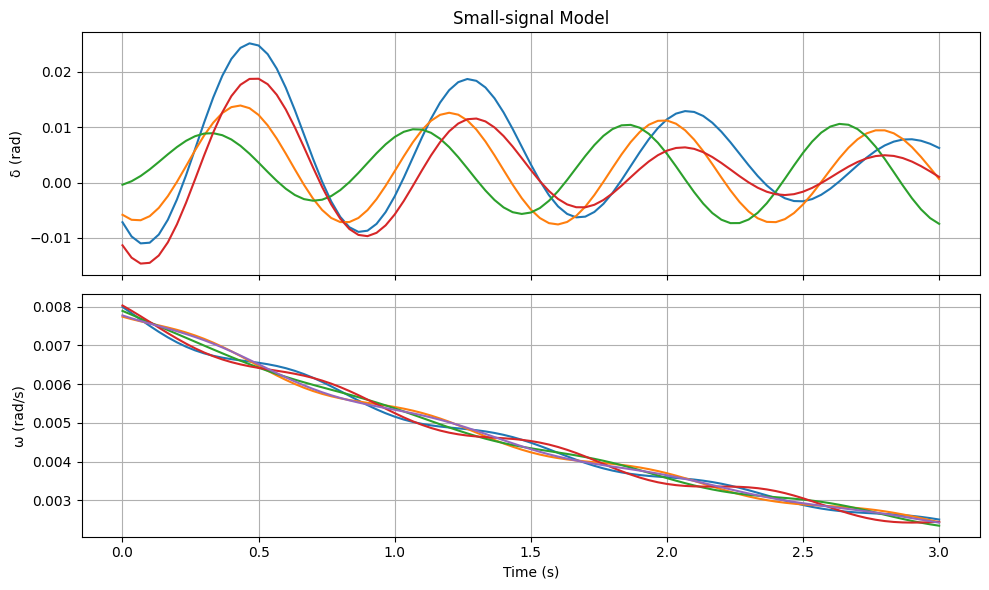

In [13]:
%matplotlib inline
# Assuming sol.y is shaped (10, N)
omega = sol.y[4:, :]  # rows 5-9
delta = sol.y[:4, :]  # rows 0-4
time = sol.t

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot all delta curves
for i in range(4):
    axes[0].plot(time, delta[i], label=f'δ_g{i+1}')
axes[0].set_ylabel('δ (rad)')
axes[0].set_title('Small-signal Model')
axes[0].grid(True)
# axes[0].legend()
# axes[0].set_ylim(0, 0.15) 

# Plot all omega curves
for i in range(5):
    axes[1].plot(time, omega[i], label=f'ω_g{i+1}')
axes[1].set_ylabel('ω (rad/s)')
# axes[1].set_title('Angular Velocities (ω)')
axes[1].set_xlabel('Time (s)')
axes[1].grid(True)
# axes[1].legend()
# axes[1].set_ylim(0.0, 0.0002)  # 


plt.tight_layout()
plt.show()

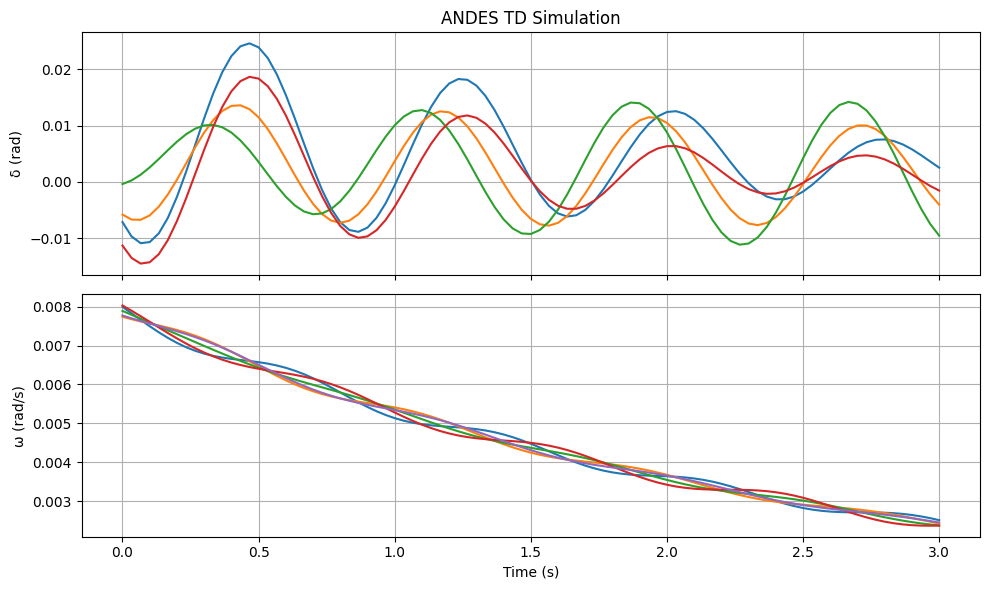

In [14]:
%matplotlib inline
# Assuming sol.y is shaped (10, N)
val_data_3 = T @ val_data_1[:,1:].T
omega_non = val_data_3[4:,:]  # rows 5-9
delta_non = val_data_3[:4,:]  # rows 0-4
time_non = val_data_1[:,0] - 2.00

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot all delta curves
for i in range(4):
    axes[0].plot(time_non, delta_non[i], label=f'δ_g{i+1}')
axes[0].set_ylabel('δ (rad)')
axes[0].set_title('ANDES TD Simulation')
axes[0].grid(True)
# axes[0].legend()
# axes[0].set_ylim(0, 0.15) 

# Plot all omega curves
for i in range(5):
    axes[1].plot(time_non, omega_non[i], label=f'ω_g{i+1}')
axes[1].set_ylabel('ω (rad/s)')
# axes[1].set_title('Angular Velocities (ω)')
axes[1].set_xlabel('Time (s)')
axes[1].grid(True)
# axes[1].legend()
# axes[1].set_ylim(0.0, 0.0002)  #


plt.tight_layout()
plt.show()

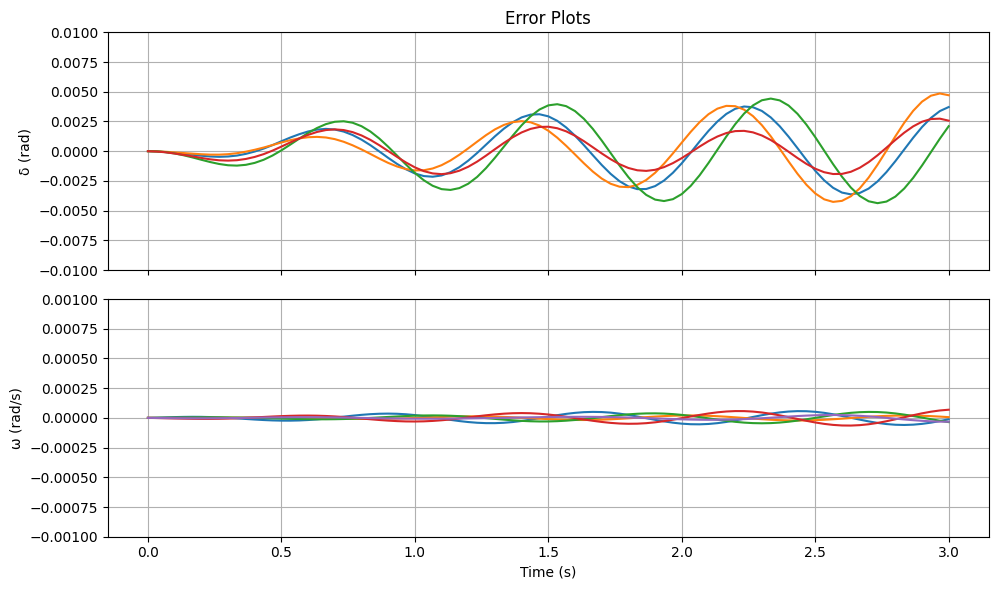

In [15]:
err_delta = (delta - delta_non)
err_omega = (omega - omega_non)

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot all delta curves
for i in range(4):
    axes[0].plot(time_non, err_delta[i], label=f'δ_g{i+1}')
axes[0].set_ylabel('δ (rad)')
axes[0].set_title('Error Plots')
axes[0].grid(True)
# axes[0].legend()
axes[0].set_ylim(-0.01, 0.01) 

# Plot all omega curves
for i in range(5):
    axes[1].plot(time_non, err_omega[i], label=f'ω_g{i+1}')
axes[1].set_ylabel('ω (rad/s)')
# axes[1].set_title('Error Angular Velocities (ω)')
axes[1].set_xlabel('Time (s)')
axes[1].grid(True)
# axes[1].legend()
axes[1].set_ylim(-0.001, 0.001)  #


plt.tight_layout()
plt.show()